In [1]:
import time
start_time = time.time()

# Titanic Data Science Solutions

### This notebook is a rewrite to the solution notebook [Data Science Solutions](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook). 


In [4]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [58]:
# example code

import pandas as pd
import cupy as cp

train_df = pd.read_csv('./input_Titanic/train_1M.csv') 
test_df = pd.read_csv('./input_Titanic/test_1M.csv') 
combine = pd.concat([train_df, test_df], axis = 0) 

In [13]:
# example code

filtered_df = train_df[(train_df['Age'] > 30) & (train_df['Fare'] > 50)] 
grouped_df = train_df.groupby('Embarked')[['Fare', 'Age']].mean() 
additional_info = pd.DataFrame({ 
	'PassengerId': [1, 2, 3], 
	'VIP_Status': ['No', 'Yes', 'No'] 
}) 
merged_df = train_df.merge(additional_info, on='PassengerId', how='left') 


In [61]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import cupy as cp
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Acquire data

In [85]:
train = pd.read_csv('./input_Titanic/train.csv')
test = pd.read_csv('./input_Titanic/test.csv')

In [86]:
target_rows = 1_000_000
repeats = -(-target_rows // len(train))  # Ceiling division
train_df = pd.concat([train] * repeats, ignore_index=True).head(target_rows)
print(train_df.shape)  # (1000000, 2)


repeats = -(-target_rows // len(test))  # Ceiling division
test_df = pd.concat([test] * repeats, ignore_index=True).head(target_rows)
print(test_df.shape)  # (1000000, 2)

(1000000, 12)
(1000000, 11)


In [87]:
combine = [train_df, test_df]

## Analyze by describing data

In [88]:
%%cudf.pandas.profile
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


                                                                                                     
                                      Total time elapsed: 0.194 seconds                              
                                    0 GPU function calls in 0.000 seconds                            
                                    1 CPU function calls in 0.001 seconds                            
                                                                                                     
                                                    Stats                                            
                                                                                                     
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function        ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ ndarray.__str__ │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└─────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- ndarray.__str__

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=597328;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [89]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,<NA>,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,<NA>,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,<NA>,S


In [90]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
999995,294,0,3,"Haas, Miss. Aloisia",female,24.0,0,0,349236,8.8500,<NA>,S
999996,295,0,3,"Mineff, Mr. Ivan",male,24.0,0,0,349233,7.8958,<NA>,S
999997,296,0,1,"Lewy, Mr. Ervin G",male,<NA>,0,0,PC 17612,27.7208,<NA>,C
999998,297,0,3,"Hanna, Mr. Mansour",male,23.5,0,0,2693,7.2292,<NA>,C
999999,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S


In [91]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   PassengerId  1000000 non-null  int64
 1   Survived     1000000 non-null  int64
 2   Pclass       1000000 non-null  int64
 3   Name         1000000 non-null  object
 4   Sex          1000000 non-null  object
 5   Age          801349 non-null   float64
 6   SibSp        1000000 non-null  int64
 7   Parch        1000000 non-null  int64
 8   Ticket       1000000 non-null  object
 9   Fare         1000000 non-null  float64
 10  Cabin        228949 non-null   object
 11  Embarked     997755 non-null   object
dtypes: float64(2), int64(5), object(5)
memory usage: 111.2+ MB


In [92]:
train_df.info()
print('_'*40)
test_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   PassengerId  1000000 non-null  int64
 1   Survived     1000000 non-null  int64
 2   Pclass       1000000 non-null  int64
 3   Name         1000000 non-null  object
 4   Sex          1000000 non-null  object
 5   Age          801349 non-null   float64
 6   SibSp        1000000 non-null  int64
 7   Parch        1000000 non-null  int64
 8   Ticket       1000000 non-null  object
 9   Fare         1000000 non-null  float64
 10  Cabin        228949 non-null   object
 11  Embarked     997755 non-null   object
dtypes: float64(2), int64(5), object(5)
memory usage: 111.2+ MB
________________________________________
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype
---  ------       ----------

**What is the distribution of numerical feature values across the samples?**

In [93]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1000000.000000,1000000.000000,1000000.000000,801349.000000,1000000.000000,1000000.000000,1000000.000000
mean,445.911643,0.383830,2.308664,29.698868,0.523036,0.381595,32.203247
std,257.226386,0.486318,0.835595,14.516406,1.102177,0.805602,49.664311
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,669.000000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**What is the distribution of categorical features?**

In [94]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [95]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1000000,1000000,1000000,228949,997755
unique,891,2,681,147,3
top,"Allison, Miss. Helen Loraine",male,CA. 2343,G6,S
freq,1123,647586,7857,4491,722783


## Analyze by pivoting features

In [96]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629592
1,2,0.472810
2,3,0.242378


In [97]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742028
1,male,0.188900


In [98]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535867
2,2,0.464199
0,0,0.345395
3,3,0.250000
4,4,0.166724
5,5,0.000000
6,8,0.000000


In [99]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.599893
1,1,0.550795
2,2,0.499989
0,0,0.343657
5,5,0.200107
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data

### Correlating numerical features

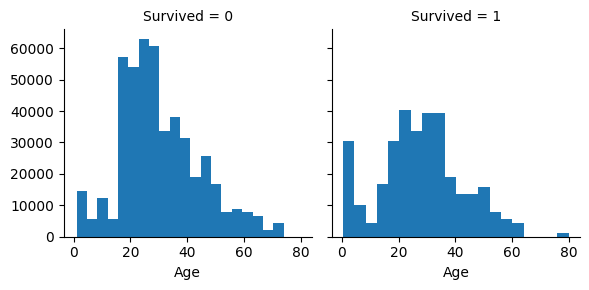

In [100]:
g = sns.FacetGrid(train_df.dropna(subset=['Age']), col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features

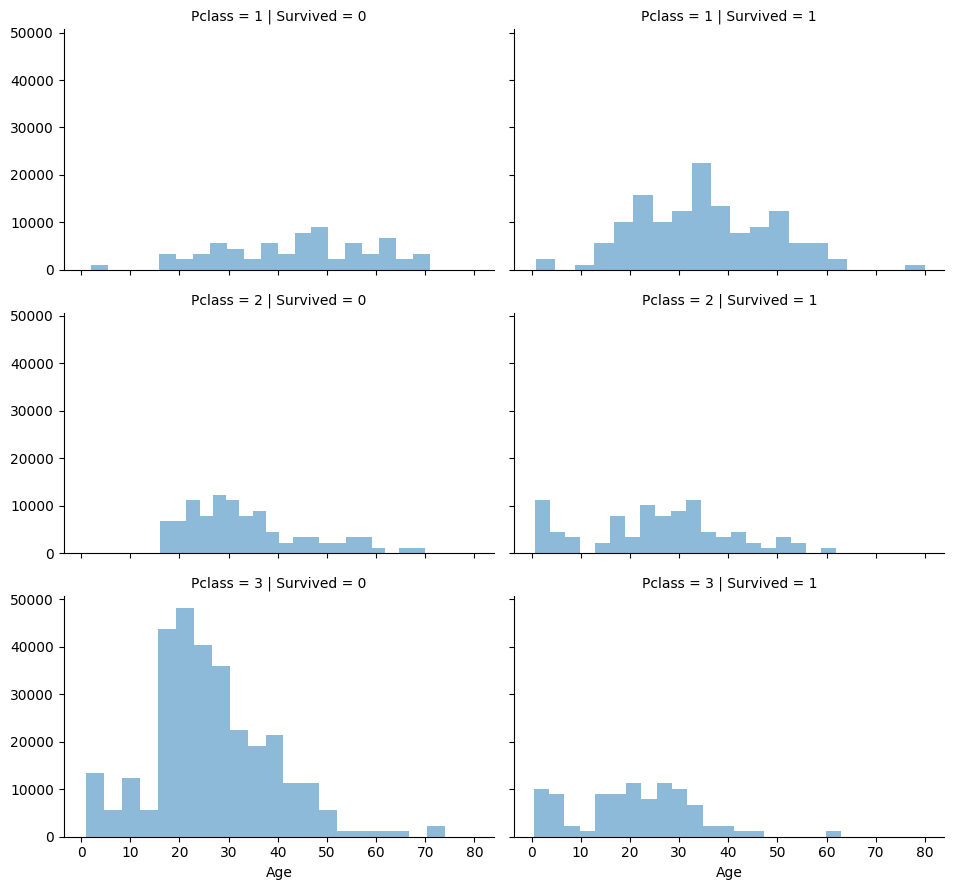

In [101]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df.dropna(subset=['Age']), col='Survived', row='Pclass', aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

### Correlating categorical features

/home/ubuntu/.venv/lib/python3.12/site-packages/cudf/core/indexed_frame.py:3617: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
  warnings.warn(
/home/ubuntu/.venv/lib/python3.12/site-packages/cudf/core/indexed_frame.py:3617: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
  warnings.warn(
/home/ubuntu/.venv/lib/python3.12/site-packages/cudf/core/indexed_frame.py:3617: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
  warnings.warn(


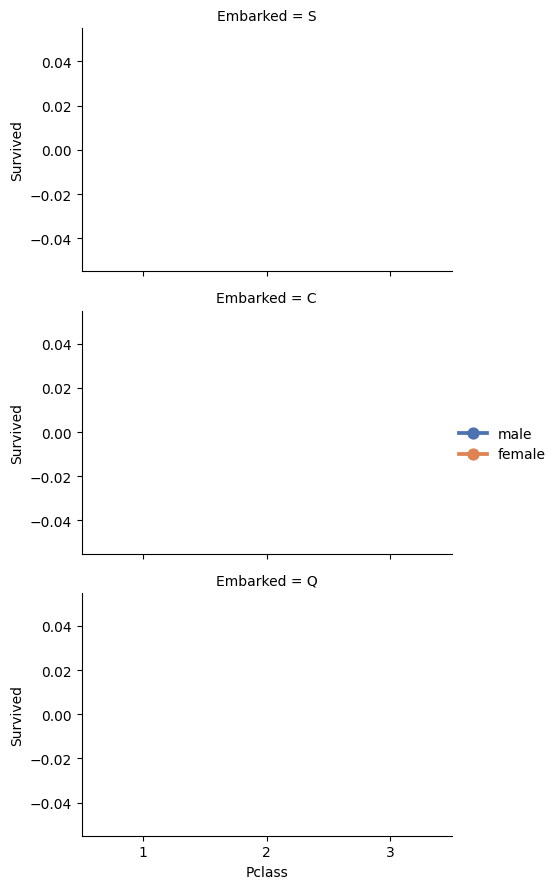

In [102]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=[1, 2, 3],  hue_order=['male', 'female'])
grid.add_legend()

### Correlating categorical and numerical features

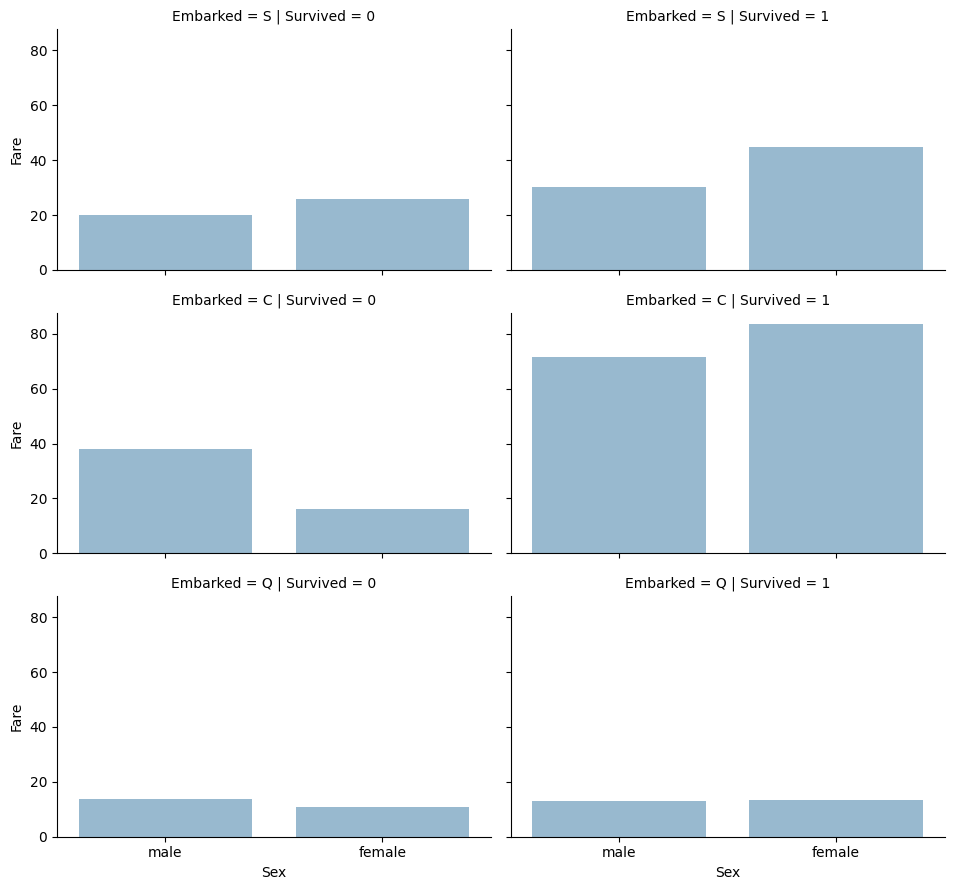

In [103]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, errorbar=None, order=['male', 'female'])
grid.add_legend()

## Wrangle data

### Correcting by dropping features

In [105]:
%%time

print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (1000000, 12) (1000000, 11) (1000000, 12) (1000000, 11)
After (1000000, 10) (1000000, 9) (1000000, 10) (1000000, 9)
CPU times: user 7.62 ms, sys: 0 ns, total: 7.62 ms
Wall time: 17.5 ms


### Creating new feature extracting from existing

In [106]:
%%timeit

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

89.4 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can replace many titles with a more common name or classify them as `Rare`.

In [108]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.574925
1,Miss,0.702693
2,Mr,0.156669
3,Mrs,0.793644
4,Rare,0.347759


We can convert the categorical titles to ordinal.

In [109]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [110]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((1000000, 9), (1000000, 9))

### Converting a categorical feature

In [111]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

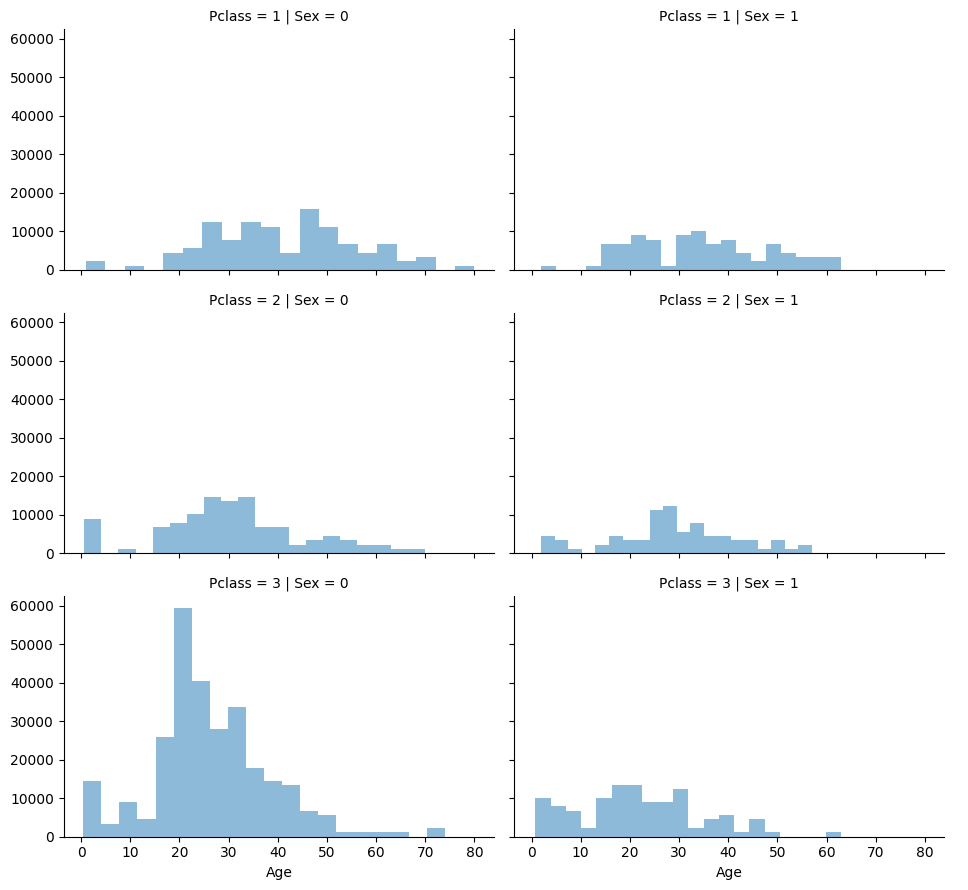

In [112]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df.dropna(subset = ['Age']), row='Pclass', col='Sex', aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [113]:
guess_ages = cp.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [114]:
type(guess_ages)

cupy.ndarray

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [115]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset.loc[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1), 'Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i, j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
            mask = (dataset['Age'].isnull()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)
            
            dataset.loc[mask, 'Age'] = guess_ages[i, j].get()

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Let us create Age bands and determine correlations with Survived.

In [116]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False, observed = True).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.549973
1,"(16.0, 32.0]",0.337376
2,"(32.0, 48.0]",0.412019
3,"(48.0, 64.0]",0.434755
4,"(64.0, 80.0]",0.090872


Let us replace Age with ordinals based on these bands.

In [117]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


We can not remove the AgeBand feature.

In [118]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing features

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [119]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724127
2,3,0.578411
1,2,0.552758
6,7,0.333457
0,1,0.303542
4,5,0.199929
5,6,0.136349
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [120]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505619
1,1,0.303542


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [121]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


We can also create an artificial feature combining Pclass and Age.

In [122]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [123]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [124]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553533
1,Q,0.389642
2,S,0.339005


### Converting categorical feature to numeric

We can now convert the EmbarkedFill feature by creating a new numeric Port feature.

In [125]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Quick completing and converting a numeric feature

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

In [126]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


We can not create FareBand.

In [127]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False, observed=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197333
1,"(7.896, 14.454]",0.303565
2,"(14.454, 31.0]",0.454943
3,"(31.0, 512.329]",0.581045


In [128]:
num_bins = 4
quantiles = cp.percentile(cp.array(train_df['Fare']), q=cp.linspace(0, 100, num_bins + 1))
bin_indices = cp.digitize(cp.array(train_df['Fare']), bins=quantiles, right=True) - 1
labels = [f"({cp.round(quantiles[i], 3)}, {cp.round(quantiles[i+1], 3)}]" for i in range(0, num_bins)]
train_df['FareBand'] = pd.Series([labels[int(i)] if 0 <= i < len(labels) else None for i in bin_indices])
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(0.0, 7.896]",0.206753
1,"(14.454, 31.0]",0.454943
2,"(31.0, 512.329]",0.581045
3,"(7.896, 14.454]",0.303565


Convert the Fare feature to ordinal values based on the FareBand.

In [129]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


And the test dataset.

In [130]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## Model, predict and solve

In [132]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((1000000, 8), (1000000,), (1000000, 8))

In [133]:
# machine learning
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC, LinearSVC
from cuml.ensemble import RandomForestClassifier
from cuml.neighbors import KNeighborsClassifier
from cuml.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold

In [134]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = cp.round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

[W] [08:23:19.855936] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


array(80.36)

In [135]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = logreg.coef_.T

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.295337
5,Title,0.391337
2,Age,0.294605
4,Embarked,0.262620
6,IsAlone,0.140626
3,Fare,-0.094844
7,Age*Class,-0.318471
0,Pclass,-0.771638


In [136]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train.astype('float64'), Y_train.astype('float64'))
Y_pred = svc.predict(X_test.astype('float64'))
acc_svc = cp.round(svc.score(X_train.astype('float64'), Y_train.astype('float64')) * 100, 2)
acc_svc

array(83.5)

In [137]:
# K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = cp.round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

array(84.96)

In [138]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train.astype('float64'), Y_train)
Y_pred = gaussian.predict(cp.array(X_test))
acc_gaussian = cp.round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

array(72.28)

In [139]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = cp.round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

array(73.4)

In [140]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(cp.array(X_train.astype('float64')), cp.array(Y_train))
Y_pred = linear_svc.predict(cp.array(X_test))
acc_linear_svc = cp.round(linear_svc.score(cp.array(X_train), cp.array(Y_train)) * 100, 2)
acc_linear_svc

array(78.9)

In [187]:
# Stochastic Gradient Descent

# sgd = SGD(loss = 'log')
# sgd.fit(X_train, Y_train)
# Y_pred = sgd.predict(X_test)
# score = ((sgd.predict(X_train) == Y_train)/len(X_train))
# print(score)
# acc_sgd = cp.round(score * 100, 2)
# acc_sgd

In [141]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = cp.round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

array(86.76)

In [142]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(cp.array(X_train), cp.array(Y_train))
Y_pred = random_forest.predict(cp.array(X_test))
random_forest.score(cp.array(X_train), cp.array(Y_train))
acc_random_forest = cp.round(random_forest.score(cp.array(X_train), cp.array(Y_train)) * 100, 2)
acc_random_forest

array(84.06)

### Model evaluation

In [143]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
            #   'Stochastic Gradient Decent', 
              'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
            #   acc_sgd, 
              acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Decision Tree,86.76
1,KNN,84.96
3,Random Forest,84.06
0,Support Vector Machines,83.50
2,Logistic Regression,80.36
6,Linear SVC,78.90
5,Perceptron,73.40
4,Naive Bayes,72.28


In [144]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)

### Stacking Generalization Approach

Use the averaged model prediction results from the base models (Random Forest, Decision Tree, KNN, Support Vector Machines, Naive Bayes) to train the meta model (Logistic Regression)

In [145]:
X_train_np = cp.array(X_train.astype('float32')).get()
Y_train_np = cp.array(Y_train).get()

In [146]:
%%time

base_models = [
    ('rf', random_forest),
    ('dt', decision_tree),
    ('knn', knn)
    # ('svm', svc),
    # ('nb', gaussian)
]

meta_model = logreg

cv = StratifiedKFold(n_splits = 5)

stacking_clf = StackingClassifier(
    estimators = base_models, 
    final_estimator = meta_model,
    cv = cv
)

stacking_clf.fit(X_train_np, Y_train_np)
acc_stacking = round(stacking_clf.score(X_train_np, Y_train_np) * 100, 2)
acc_stacking

[I] [08:28:34.750373] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [08:28:45.847614] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [08:28:45.924627] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [08:28:47.377667] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [08:28:48.831639] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [08:28:50.286238] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [08:28:51.740961] Unused keyword parameter: n_jobs during cuML estimator initialization
CPU times: user 27 s, sys: 20 s, total: 47 s
Wall time: 29.5 s


86.75

## References

This notebook has been created based on great work done solving the Titanic competition and other sources.

- [A journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic)
- [Getting Started with Pandas: Kaggle's Titanic Competition](https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests)
- [Titanic Best Working Classifier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)

In [147]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f'Total execution time: {elapsed_time} seconds')

Total execution time: 202549.64148688316 seconds
